In [1]:
from common import *
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import logging, time
from sklearn.model_selection import train_test_split
import data_flow
import train
import gc

# Prepare data

In [2]:
fnames = glob('../data/corpus/**.txt')

In [134]:
word_embeddings = np.load(join(DATA_FOLDER, 'word_embeddings_300.npy'))
with open(join(DATA_FOLDER, "dictionary.pickle"), "rb") as input_file:
    index2word = pickle.load(input_file)

In [143]:
docs = []
ids = []
for fn in tqdm_notebook(fnames[:]):
    with open(fn, 'rb') as f:
        ixs = [int(_ix) for _ix in f.read().split()]
    if len(ixs) == 0:
        print(fn)
        continue
    doc_vec = word_embeddings[ixs].mean(axis=0)
    docs.append(doc_vec)
    ids.append(basename(fn).split('.')[0])

../data/corpus/5984b653b6b11311aa638537.txt
../data/corpus/5984b69db6b1131591638547.txt
../data/corpus/5984b6fdb6b1131ae26384f4.txt
../data/corpus/5984b667b6b11313926384f7.txt
../data/corpus/5984b690b6b113159263850f.txt
../data/corpus/5984b65db6b1131294638541.txt
../data/corpus/5984b6bab6b11317b963851c.txt
../data/corpus/5984b592b6b113049f638531.txt
../data/corpus/5984b6bab6b11317a16384fd.txt
../data/corpus/5984b6a3b6b11316a563850e.txt
../data/corpus/5984b589b6b11304986384fd.txt
../data/corpus/5984b6c1b6b11317b0638527.txt
../data/corpus/5984b6bbb6b11317a163852f.txt
../data/corpus/5984b6bbb6b11317a1638546.txt
../data/corpus/5984b58fb6b1130489638517.txt
../data/corpus/5984b68fb6b11315926384f3.txt
../data/corpus/5984b68fb6b1131592638508.txt
../data/corpus/5984b58fb6b11304a963852e.txt
../data/corpus/5984b6bbb6b11317a1638536.txt
../data/corpus/5984b6a4b6b113169a638532.txt
../data/corpus/5984b6bab6b11317a163850f.txt
../data/corpus/5984b6c2b6b11317b8638545.txt
../data/corpus/5984b6c1b6b11317b

In [146]:
np.save('../data/avged_docs.npy', docs)
np.save('../data/avged_ids.npy', ids)

# Load data

In [2]:
with open(join(DATA_FOLDER, 'sims.json'), 'r') as f:
    sims = json.load(f)
with open(join(DATA_FOLDER, 'gold_mongo.json'), 'r') as f:
    gold = json.load(f)

In [3]:
docs = np.load('../data/avged_docs.npy')
ids = np.load('../data/avged_ids.npy')
docs = pd.DataFrame(docs, index=ids)
docs.sort_index(inplace=True)

# try unsupervised

In [42]:
val_vecs = []
for _id in tqdm_notebook(gold.keys()):
    ix = np.where(ids == _id)[0][0]
    val_vecs.append(docs[ix])

In [46]:
sim_mat = cosine_similarity(val_vecs, docs)

In [52]:
best = {}
for i, vec in enumerate(tqdm(sim_mat)):
    val_name = gold.keys()[i]
    train_ixs = vec.argsort()[-200:][::-1]
    top_train = [ids[i] for i in train_ixs]
    best[val_name] = top_train

100%|██████████| 184/184 [00:28<00:00,  6.53it/s]


100%|██████████| 184/184 [00:00<00:00, 16783.78it/s]


median
acc10     0.0
acc20     0.0
acc200    0.5
dtype: float64
mean
acc10     0.273007
acc20     0.355435
acc200    0.535145
dtype: float64


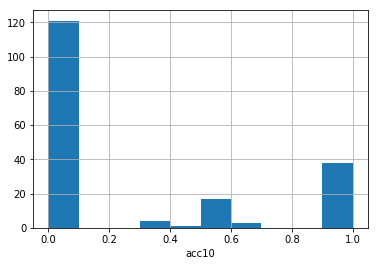

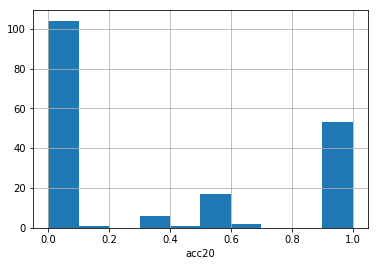

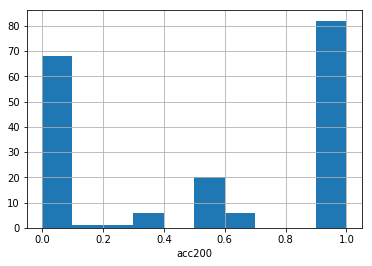

In [57]:
result = evaluate(best, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

# try supervised

In [4]:
triples_all = list(data_flow.random_triples(sims, ids, num_epochs=1, with_path=False, seed=1))
_triples, triples_test = train_test_split(triples_all, test_size=0.1, random_state=0)
triples_train, triples_val = train_test_split(_triples, test_size=0.1, random_state=0)
gc.collect()

100%|██████████| 368458/368458 [00:04<00:00, 87415.00it/s] 


0

# No batch normalization

In [ ]:
embedding_size = 300
batch_size = 64
learning_rate = 0.1
sizes=[300, 200]

In [ ]:
reload(train)

logging.info('start training ...')
start_time = time.time()

finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        X = tf.placeholder('float32', (None, embedding_size), name='X')

        model = train.FCNN(batch_size=batch_size, sizes=sizes, 
                        learning_rate=learning_rate,
                        batch_norm=False)
        train_op = model.optimize(X)

        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        model.init_summary('train')
#         model.init_summary('val')

        tr_batch = data_flow.gen_batches(docs, triples_train[:1000*batch_size], batch_size)
#         val_batch = data_flow.gen_batches(docs, triples_val, 64)

        for step, X_train in enumerate(tr_batch):
            assert not X_train.isnull().values.any()
            _, loss, summary, _embeds = sess.run([
                train_op, model.loss_op,
                model.merged_summary_op, model.negative
            ], feed_dict = {model.phase: 1, 'X:0': X_train})
            model.add_summary(summary, step)
            logging.info('step %s, loss %s' % (step, loss))
            
#             if (step + 1) %  50 == 0:
#                 X_val = next(val_batch)
#                 [val_loss] = sess.run([loss], 
#                               feed_dict={'X:0': X_val,
#                                          'phase:0': 0})
#             if (step + 1) %  50 == 0:
#                 [test_loss, t20, t200] = sess.run([loss, top20, top200], 
#                              feed_dict={'X:0': X_test,
#                                         'phase:0': 0})
        model.save(step)
        finished = True

except Exception as e:
    logging.exception("train error")
#     send_email('notebook_url', subject='train error', body=e)
finally:
    if finished:
#     send_email('notebook_url', subject='finished training')
        pass
        
logging.info("--- %s seconds ---" % (time.time() - start_time))

2017-09-26 12:46:24,568 [MainThread  ] [INFO ]  start training ...
2017-09-26 12:46:26,790 [MainThread  ] [INFO ]  step 0, loss 0.0246231
2017-09-26 12:46:26,816 [MainThread  ] [INFO ]  step 1, loss 0.193446
2017-09-26 12:46:26,942 [MainThread  ] [INFO ]  step 2, loss 0.138571
2017-09-26 12:46:26,960 [MainThread  ] [INFO ]  step 3, loss 0.0880808
2017-09-26 12:46:26,973 [MainThread  ] [INFO ]  step 4, loss 0.108038
2017-09-26 12:46:26,986 [MainThread  ] [INFO ]  step 5, loss 0.0834588
2017-09-26 12:46:27,002 [MainThread  ] [INFO ]  step 6, loss 0.0840769
2017-09-26 12:46:27,019 [MainThread  ] [INFO ]  step 7, loss 0.0736942
2017-09-26 12:46:27,036 [MainThread  ] [INFO ]  step 8, loss 0.0898689
2017-09-26 12:46:27,050 [MainThread  ] [INFO ]  step 9, loss 0.0562397
2017-09-26 12:46:27,065 [MainThread  ] [INFO ]  step 10, loss 0.0427516
2017-09-26 12:46:27,084 [MainThread  ] [INFO ]  step 11, loss 0.0902829
2017-09-26 12:46:27,100 [MainThread  ] [INFO ]  step 12, loss 0.0716068
2017-09-26

2017-09-26 12:46:29,491 [MainThread  ] [INFO ]  step 113, loss 0.0184822
2017-09-26 12:46:29,506 [MainThread  ] [INFO ]  step 114, loss 0.0278372
2017-09-26 12:46:29,520 [MainThread  ] [INFO ]  step 115, loss 0.00628317
2017-09-26 12:46:29,534 [MainThread  ] [INFO ]  step 116, loss 0.0225291
2017-09-26 12:46:29,546 [MainThread  ] [INFO ]  step 117, loss 0.0145395
2017-09-26 12:46:29,560 [MainThread  ] [INFO ]  step 118, loss 0.0307156
2017-09-26 12:46:29,665 [MainThread  ] [INFO ]  step 119, loss 0.0322414
2017-09-26 12:46:29,682 [MainThread  ] [INFO ]  step 120, loss 0.0119007
2017-09-26 12:46:29,698 [MainThread  ] [INFO ]  step 121, loss 0.0134013
2017-09-26 12:46:29,712 [MainThread  ] [INFO ]  step 122, loss 0.0197086
2017-09-26 12:46:29,724 [MainThread  ] [INFO ]  step 123, loss 0.0121345
2017-09-26 12:46:29,738 [MainThread  ] [INFO ]  step 124, loss 0.0123139
2017-09-26 12:46:29,751 [MainThread  ] [INFO ]  step 125, loss 0.0265566
2017-09-26 12:46:29,765 [MainThread  ] [INFO ]  st

2017-09-26 12:46:32,005 [MainThread  ] [INFO ]  step 226, loss 0.0120292
2017-09-26 12:46:32,022 [MainThread  ] [INFO ]  step 227, loss 0.00739951
2017-09-26 12:46:32,039 [MainThread  ] [INFO ]  step 228, loss 0.00624196
2017-09-26 12:46:32,056 [MainThread  ] [INFO ]  step 229, loss 0.0104164
2017-09-26 12:46:32,070 [MainThread  ] [INFO ]  step 230, loss 0.00424813
2017-09-26 12:46:32,085 [MainThread  ] [INFO ]  step 231, loss 0.00422698
2017-09-26 12:46:32,103 [MainThread  ] [INFO ]  step 232, loss 0.0273323
2017-09-26 12:46:32,116 [MainThread  ] [INFO ]  step 233, loss 0.0042448
2017-09-26 12:46:32,133 [MainThread  ] [INFO ]  step 234, loss 0.0154201
2017-09-26 12:46:32,149 [MainThread  ] [INFO ]  step 235, loss 0.00141191
2017-09-26 12:46:32,162 [MainThread  ] [INFO ]  step 236, loss 0.0103044
2017-09-26 12:46:32,175 [MainThread  ] [INFO ]  step 237, loss 0.00887779
2017-09-26 12:46:32,278 [MainThread  ] [INFO ]  step 238, loss 0.00971642
2017-09-26 12:46:32,298 [MainThread  ] [INFO

2017-09-26 12:46:34,316 [MainThread  ] [INFO ]  step 338, loss 0.0148824
2017-09-26 12:46:34,328 [MainThread  ] [INFO ]  step 339, loss 0.0149038
2017-09-26 12:46:34,342 [MainThread  ] [INFO ]  step 340, loss 0.00738497
2017-09-26 12:46:34,359 [MainThread  ] [INFO ]  step 341, loss 0.00463407
2017-09-26 12:46:34,372 [MainThread  ] [INFO ]  step 342, loss 0.0172952
2017-09-26 12:46:34,384 [MainThread  ] [INFO ]  step 343, loss 0.0110016
2017-09-26 12:46:34,397 [MainThread  ] [INFO ]  step 344, loss 0.0212926
2017-09-26 12:46:34,410 [MainThread  ] [INFO ]  step 345, loss 0.0101907
2017-09-26 12:46:34,424 [MainThread  ] [INFO ]  step 346, loss 0.0185387
2017-09-26 12:46:34,438 [MainThread  ] [INFO ]  step 347, loss 0.0187736
2017-09-26 12:46:34,451 [MainThread  ] [INFO ]  step 348, loss 0.0191992
2017-09-26 12:46:34,466 [MainThread  ] [INFO ]  step 349, loss 0.00538225
2017-09-26 12:46:34,478 [MainThread  ] [INFO ]  step 350, loss 0.0317709
2017-09-26 12:46:34,582 [MainThread  ] [INFO ]  

In [14]:
step

618

In [10]:
_embeds

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)

In [20]:
np.argmax(X_train.isnull().sum(axis=1))

u'5984b6a4b6b113169a638519'

# Test

In [92]:
model_dir = join(DATA_FOLDER, 'models')
!ls {model_dir+'/*.meta'}

../data/models/2017-09-26 09:59:37.272917-999.meta


In [93]:
def last_model(model_dir):
    fnames = glob(join(model_dir, '*.meta'))
    return max(fnames)

In [94]:
doc_embeds, fnames = [], []

In [82]:
X_train[150:200]

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
5984cfdcb6b11339ac638507,-0.070904,-0.079025,0.037895,0.124674,0.042777,-0.115827,-0.093083,-0.011540,0.211427,-0.157393,...,0.124957,-0.044020,-0.048094,0.118328,-0.133080,0.178457,0.068682,0.060002,-0.072113,-0.006197
5984b60eb6b1130a67638525,-0.093332,-0.134331,0.042862,0.091322,0.039671,-0.170402,-0.087734,-0.076436,0.171415,-0.184669,...,0.095422,-0.037501,-0.061237,0.083233,-0.122674,0.217525,0.042071,0.102225,-0.085225,0.063532
5984c767b6b113669c638514,-0.135280,-0.273250,0.094752,0.083100,-0.101050,-0.082634,-0.085032,0.042411,0.186556,-0.075589,...,0.002963,0.070030,-0.005793,0.109597,-0.064214,0.151292,-0.031694,-0.191872,-0.034893,-0.017515
5984bcb7b6b11367e863852a,-0.086554,-0.165618,0.034228,-0.010814,-0.012863,-0.099385,-0.199918,-0.141837,0.189886,-0.099551,...,0.158592,0.053811,-0.082791,0.046680,-0.018892,0.008599,0.028640,-0.006407,0.100354,0.107548
5984b9f3b6b11348b46384f9,-0.050859,-0.167190,0.022801,0.024430,-0.016376,-0.128197,-0.188375,-0.086630,0.190439,-0.121576,...,0.120927,0.058621,-0.090057,0.048432,-0.035487,0.056100,0.080672,0.014886,0.097365,0.097629
5984b84bb6b1132eed63850a,0.077113,-0.139069,0.067594,0.115411,0.022458,-0.181884,-0.113269,0.043151,0.160398,-0.097980,...,0.091350,-0.008239,-0.110971,0.042128,-0.094551,0.133188,0.069467,0.021368,-0.010850,0.148509
5984d127b6b11342e563853d,-0.214958,-0.284785,0.073127,0.074833,-0.081186,-0.091073,-0.132739,0.064680,0.277427,-0.082780,...,0.040122,-0.037749,-0.048169,0.150314,-0.006512,0.198596,-0.130207,-0.175246,-0.045839,-0.044711
5984c953b6b1137aab638510,-0.161499,-0.288309,0.092800,0.092653,-0.083072,-0.090371,-0.083609,0.040919,0.247058,-0.101859,...,0.071387,0.042631,-0.036093,0.136812,-0.009811,0.173574,-0.092945,-0.168592,-0.038722,-0.044352
5984d891b6b11311c6638512,-0.068388,-0.110483,0.038842,0.043768,0.007147,-0.120908,-0.200254,-0.042018,0.182779,-0.116661,...,0.109574,-0.008917,-0.142562,0.052248,-0.070965,0.062712,0.106728,-0.016387,0.060623,0.074611
5984ca1eb6b113032e638502,0.007926,-0.203619,0.054011,0.034557,-0.032630,-0.109608,-0.154564,-0.086624,0.222286,-0.027600,...,0.106201,0.049224,-0.178163,0.031375,-0.109470,-0.069428,0.119329,-0.040990,-0.088505,-0.013060


In [95]:
finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)    
    with sess.as_default():
        X = tf.placeholder('float32', (None, embedding_size), name='X')
        phase = tf.placeholder(tf.bool, name='phase') 
        
        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        # do not restore before global initialization, otherwise all weights are set to default !!!
        saver = tf.train.import_meta_graph(last_model(model_dir), input_map={'X':X})
        saver.restore(sess, tf.train.latest_checkpoint(model_dir))
        graph = tf.get_default_graph()

        op_name = 'optimize/loss/doc_embed_normalized'
        doc_embed_normalized = graph.get_operation_by_name(op_name).outputs[0]

        anchor, positive, negative = tf.unstack(
            tf.reshape(doc_embed_normalized, [-1, 3, sizes[-1]]),
            3, 1)
        _loss = train.triplet_loss(anchor, positive, negative)

#         pprint([n.name for n in tf.get_default_graph().as_graph_def().node])

        test_batch = data_flow.gen_batches(docs, triples_test[:100*batch_size], batch_size)

        step = 0
        for step, X_test in enumerate(test_batch):
            [batch_embeds, loss] = sess.run([doc_embed_normalized, _loss],
                                           feed_dict = {phase: 0, 'X:0': X_test})
            doc_embeds.append(batch_embeds)
            logging.info('step %s, loss %s' % (step, loss))
            step+=1
        finished = True
        
except Exception as e:
    logging.exception("test error")
#     send_email('notebook_url', subject='test error', body=e)
finally:
    if finished:
#         send_email('notebook_url', subject='finished testing')
        pass

INFO:tensorflow:Restoring parameters from ../data/models/2017-09-26 09:59:37.272917-999


2017-09-26 10:02:50,512 [MainThread  ] [INFO ]  Restoring parameters from ../data/models/2017-09-26 09:59:37.272917-999
2017-09-26 10:02:50,687 [MainThread  ] [INFO ]  step 0, loss 0.0
2017-09-26 10:02:50,693 [MainThread  ] [INFO ]  step 1, loss 0.0
2017-09-26 10:02:50,698 [MainThread  ] [INFO ]  step 2, loss 0.0
2017-09-26 10:02:50,708 [MainThread  ] [INFO ]  step 3, loss 0.0
2017-09-26 10:02:50,715 [MainThread  ] [INFO ]  step 4, loss 0.0
2017-09-26 10:02:50,720 [MainThread  ] [INFO ]  step 5, loss 0.0
2017-09-26 10:02:50,728 [MainThread  ] [INFO ]  step 6, loss 0.0
2017-09-26 10:02:50,734 [MainThread  ] [INFO ]  step 7, loss 0.0
2017-09-26 10:02:50,825 [MainThread  ] [INFO ]  step 8, loss 0.0
2017-09-26 10:02:50,831 [MainThread  ] [INFO ]  step 9, loss 0.0
2017-09-26 10:02:50,837 [MainThread  ] [INFO ]  step 10, loss 0.0
2017-09-26 10:02:50,842 [MainThread  ] [INFO ]  step 11, loss 0.0
2017-09-26 10:02:50,848 [MainThread  ] [INFO ]  step 12, loss 0.0
2017-09-26 10:02:50,855 [MainThr

# Develop

In [83]:
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(0)
    sess = tf.Session()
    with sess.as_default():

        arr = np.array([[1,2,3], [4,5,6], [7,8,9]], dtype=np.float32)
        
        m = tf.nn.l2_normalize(arr, dim=1)
        
        sess.run(tf.global_variables_initializer())
        
        [res] = sess.run([m])
        print(res)


[[ 0.26726124  0.53452247  0.80178368]
 [ 0.45584232  0.56980288  0.6837635 ]
 [ 0.50257069  0.57436651  0.64616233]]


In [84]:
np.array([1.,2.,3.])/np.sqrt(1+4+9)

array([ 0.26726124,  0.53452248,  0.80178373])

In [81]:
0.26726124**2 + 0.53452247**2 + 0.80178368**2

0.9999999108555808